## Introduction
Computer vision models can learn to recognize complex patterns and objects in images. However, they often struggle to generalize to new input. One solution is data augmentation, a technique that expands the size and diversity of a dataset by creating variations of existing images. The model never sees the exact image twice, helping it learn general features versus memorizing specific examples.

In this post, I will explore how different augmentations can impact model performance using a hand gesture dataset. Hand gesture recognition has potential applications in human-computer interaction, robotics, and sign language interpretation. Hand gesture recognition is challenging due to the variability of hand poses, shapes, and lighting conditions, making it a good candidate for image augmentation. The results of these experiments should provide insights into the best practices for training deep learning models to handle diverse input.

## Environment Setup
The experiment code depends on the miniai library developed for the Practical Deep Learning 2022 Part 2 course. First, we'll check if we have the miniai package installed. If not, we clone the course repository from GitHub and install the miniai package.

**Install dependencies**

In [ ]:
# %%capture
# try:
#     import miniai
# except ImportError:
#     !git clone https://github.com/fastai/course22p2.git
#     !pip install -e ./course22p2

Next, we need to install several pip packages.

In [ ]:
# %%capture
# !pip install torch torchvision torchaudio torcheval
# !pip install numpy pandas pillow wandb
# !pip install cjm_pil_utils cjm_kaggle_utils cjm_pytorch_utils cjm_pandas_utils

After installing the required dependencies, we can import them into our Jupyter notebook.

**Import dependencies**

In [ ]:
from pathlib import Path
import hashlib
import json
import random
import multiprocessing
import math
import os
from functools import partial
from copy import copy
from glob import glob

from PIL import Image
import numpy as np
import timm
from tqdm.auto import tqdm

# Import pandas module for data manipulation
import pandas as pd

# Set options for Pandas DataFrame display
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

# Import PyTorch dependencies
import torch
import torch.nn as nn
from torchvision import transforms, models
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torcheval.tools import get_module_summary
from torcheval.metrics import MulticlassAccuracy

# Import miniai dependencies
import fastcore.all as fc
from miniai.datasets import DataLoaders
from miniai.conv import def_device
from miniai.learner import *
from miniai.activations import Hook, ActivationStats
from miniai.accel import MixedPrecision, AccelerateCB
from miniai.init import BatchTransformCB, GeneralRelu, init_weights, set_seed, conv
from miniai.sgd import BatchSchedCB
from miniai.resnet import ResBlock

# Import utility functions
from cjm_kaggle_utils.core import save_kaggle_creds, dl_kaggle
from cjm_pil_utils.core import resize_img, get_img_files, stack_imgs
from cjm_pytorch_utils.core import pil_to_tensor, tensor_to_pil, tensor_stats_df, get_torch_device, denorm_img_tensor
from cjm_pandas_utils.core import markdown_to_pandas

2023-03-13 12:47:22.011277: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 12:47:22.134415: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-13 12:47:22.495306: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-13 12:47:22.495343: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

## Dataset

The dataset contains images from [HaGRID](https://github.com/hukenovs/hagrid) (HAnd Gesture Recognition Image Dataset) modified for image classification. It has 125,912 samples for 18 distinct hand gestures and 27,823 images containing no gestures. The dataset includes a wide range of people, environmental settings, illumination, and camera placement. You can access the dataset on [Kaggle](https://www.kaggle.com/) at the link below.
* [HaGRID Classification 512p no_gesture 150k](https://www.kaggle.com/datasets/innominate817/hagrid-classification-512p-no-gesture-150k)

First, we set our Kaggle credentials by providing our Kaggle username and API token. We save the credentials to a file, which allows us to authenticate and download the dataset from Kaggle.

**Set Kaggle username and API token**

In [ ]:
username = ""
key = ""

**Save Kaggle credentials to file**

In [ ]:
save_kaggle_creds(username, key, overwrite=False)

Empty username.


Next, we define the directories to store the archive files and datasets and create the directories if they don't already exist.

**Set directory paths**

In [ ]:
# Define path to store datasets
dataset_dir = Path("/mnt/980_1TB_2/Datasets/")
# Create the dataset directory if it does not exist
dataset_dir.mkdir(parents=True, exist_ok=True)
print(f"Dataset Directory: {dataset_dir}")

# Define path to store archive files
archive_dir = dataset_dir/'../Archive'
# Create the archive directory if it does not exist
archive_dir.mkdir(parents=True, exist_ok=True)
print(f"Archive Directory: {archive_dir}")

Dataset Directory: /mnt/980_1TB_2/Datasets
Archive Directory: /mnt/980_1TB_2/Datasets/../Archive


We use the Kaggle dataset name to construct the save paths for the archive file and the extracted dataset.

**Set Kaggle dataset**

In [ ]:
# Set the name of the dataset
dataset_name = 'hagrid-classification-512p-no-gesture-150k'

# Construct the Kaggle dataset name by combining the username and dataset name
kaggle_dataset = f'innominate817/{dataset_name}'

# Create the path to the zip file that contains the dataset
archive_path = Path(f'{archive_dir}/{dataset_name}.zip')
print(f"Archive Path: {archive_path}")

# Create the path to the directory where the dataset will be extracted
dataset_path = Path(f'{dataset_dir}/{dataset_name}')
print(f"Dataset Path: {dataset_path}")

Archive Path: /mnt/980_1TB_2/Datasets/../Archive/hagrid-classification-512p-no-gesture-150k.zip
Dataset Path: /mnt/980_1TB_2/Datasets/hagrid-classification-512p-no-gesture-150k


Finally, we download the Kaggle dataset and extract it to the specified directory.

**Download Kaggle dataset**

In [ ]:
dl_kaggle(kaggle_dataset, archive_path, dataset_path)

Dataset already downloaded


The dataset organizes the images for different gesture types into separate subfolders.

**Get image classes**

In [ ]:
# Get all subfolders within the dataset_path
folders = [folder for folder in dataset_path.glob('*/') if folder.is_dir()]

# Store the folder names
class_names = [f.name for f in folders]

# Print the list of class names
pd.DataFrame(class_names)

,0
0,call
1,dislike
2,fist
3,four
4,like
5,mute
6,no_gesture
7,ok
8,one
9,palm


After obtaining the class names for the dataset, we need to get the paths for all the images in the dataset.

**Get image paths**

In [ ]:
# Get a list of all image file paths from the given folders
img_paths = [get_img_files(folder) for folder in folders]

# Flatten the list of lists into a single list
img_paths = [path for class_paths in img_paths for path in class_paths]

# Get the number of image file paths
len(img_paths)

153735

## Methodology

I tracked the experiment using [Weights & Biases](https://wandb.ai) and initialized all training runs with the same random seed to ensure the consistency and reproducibility of the results. I then reran the experiment with a few different seed values. You can view the Weights & Biases projects at the links below.
* [miniai_data_augmentation_seed-1](https://wandb.ai/millscj/miniai_data_augmentation_seed-1)
* [miniai_data_augmentation_seed-42](https://wandb.ai/millscj/miniai_data_augmentation_seed-42)
* [miniai_data_augmentation_seed-100](https://wandb.ai/millscj/miniai_data_augmentation_seed-100)
* [miniai_data_augmentation_seed-1234](https://wandb.ai/millscj/miniai_data_augmentation_seed-1234)

You can view the projects without an account, but you will need one to create new projects.


**Log in to Weights & Biases**

In [ ]:
import wandb
wandb.login()

wandb: Currently logged in as: millscj. Use `wandb login --relogin` to force relogin


True

**Set random number seed**

In [ ]:
# seed = 1
# seed = 42
# seed = 100
seed = 1234
set_seed(seed)

**Set device and data type**

In [ ]:
device = get_torch_device()
dtype = torch.float32
device, dtype

('cuda', torch.float32)

### Image Augmentations


For this experiment, I tested five different image augmentations. We can visualize each one using a sample image from the dataset.

**Display sample image**

Class: stop


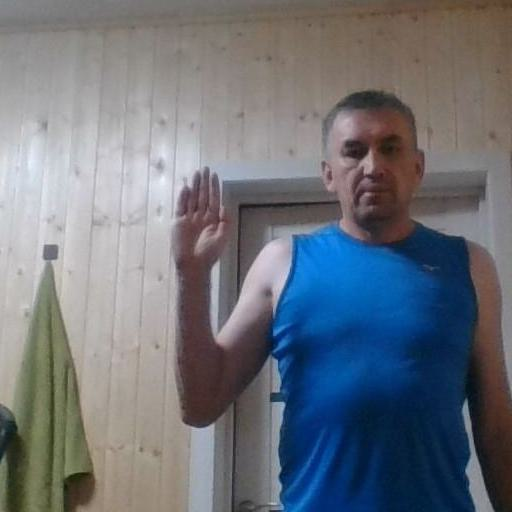

In [ ]:
# Select a random image path from the list of image paths
img_path = random.choice(img_paths)

# Print the name of the class of the image, which is the name of the parent folder
print(f"Class: {img_path.parent.name}")

# Open the image using the path
sample_img = Image.open(img_path)

# Display the image
sample_img

The first augmentation copies a square section from a random location on the image and pastes it in a random spot. I use random patch sizes ranging from 10-20% of the image dimensions to reduce the chance of obscuring the hand gestures.

**Random Square Copy Transform**

In [ ]:
def rand_square_copy(img_tensor:torch.Tensor, pct:float):
    """
    Copy data from a randomly selected square region to another randomly selected square region of an image tensor.

    Args:
    img_tensor (torch.Tensor): The input image tensor.
    pct (float): The percentage of the image tensor's size to be used as the side length of the square regions.

    Returns:
    torch.Tensor: The modified input image tensor.
    """
    
    # Get the shape of the tensor
    h, w = img_tensor.shape[-2:]
    
    # Calculate the size of the square
    szx = int(pct * h)
    szy = int(pct * w)
    
    # Calculate the top-left coordinate of the first square
    stx1 = int(random.random() * (1 - pct) * h)
    sty1 = int(random.random() * (1 - pct) * w)
    
    # Calculate the top-left coordinate of the second square
    stx2 = int(random.random() * (1 - pct) * h)
    sty2 = int(random.random() * (1 - pct) * w)
    
    # Copy the data from the second square to the first square
    img_tensor[..., stx1:stx1 + szx, sty1:sty1 + szy] = img_tensor[..., stx2:stx2 + szx, sty2:sty2 + szy]
    
    # Return the modified input img_tensor
    return img_tensor

In [ ]:
class RandSquareCopy(nn.Module):
    def __init__(self, pct=0.2, min_num=0, max_num=4):
        """
        A PyTorch module that applies the `rand_square_copy` function to an input tensor multiple times.

        Args:
        pct (float, optional): The percentage of the tensor's size to be used as the side length of 
                               the square regions.
        min_num (int, optional): The minimum number of times to apply the `rand_square_copy` function.
        max_num (int, optional): The maximum number of times to apply the `rand_square_copy` function.
        """
        super().__init__()
        self.pct = pct
        self.min_num = min_num
        self.max_num = max_num
        
    def forward(self, x): 
        # Apply the `rand_square_copy` function to the input tensor multiple times
        for i in range(random.randint(self.min_num, self.max_num)):
            x = rand_square_copy(x, max(0.1,random.random()*self.pct))
        return x

**Test the transform**

torch.Size([3, 512, 512])


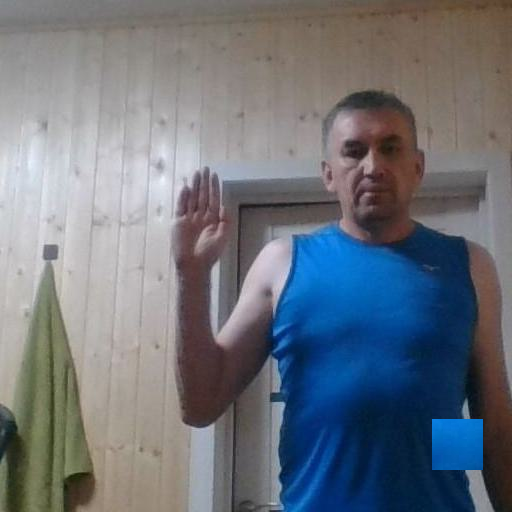

In [ ]:
rand_square_copy_tf = RandSquareCopy(pct=0.2, min_num=1, max_num=1)

# Convert the PIL image to a tensor
img_tensor = transforms.PILToTensor()(sample_img)
print(img_tensor.shape)

# Apply the `rand_square_copy_tf` transform to the image tensor
tensor_to_pil(rand_square_copy_tf(img_tensor))

The second augmentation copies random pixels and pastes them in different indices. I use random amounts ranging from 0.25-1.5% of the pixels.

**Random Pixel Copy Transform**

In [ ]:
def rand_pixel_copy(img_tensor:torch.Tensor, pct:float=0.2):
    """
    Copy data from a randomly selected set of pixels to another randomly selected set of pixels of a image tensor.

    Args:
    img_tensor (torch.Tensor): The input image tensor.
    pct (float, optional): The percentage of the total number of pixels to be selected as the source and target sets
                           of pixels.
    
    Returns:
    torch.Tensor: The modified input image tensor.
    """
    
    src_dim = img_tensor.dim()
    
    img_tensor = img_tensor.unsqueeze(0) if src_dim == 3 else img_tensor
    
    # Get the shape of the img_tensor
    b, c, h, w = img_tensor.shape
    
    # Calculate the number of pixels to be selected
    num_pixels = int(img_tensor[-1:].numel() * pct)
    
    # Select the source pixel indices
    source_indices = torch.LongTensor(num_pixels, 2).random_(0, h * w)
    source_indices[:, 0] = source_indices[:, 0] // w
    source_indices[:, 1] = source_indices[:, 1] % w
    
    # Select the target pixel indices
    target_indices = torch.LongTensor(num_pixels, 2).random_(0, h * w)
    target_indices[:, 0] = target_indices[:, 0] // w
    target_indices[:, 1] = target_indices[:, 1] % w
    
    # Get the indices of the channels
    c_indices = torch.arange(c).repeat(num_pixels, 1).t()
    
    # Copy the pixels
    source_pixels = img_tensor[:, c_indices, source_indices[:, 0], source_indices[:, 1]]
    img_tensor[:, c_indices, target_indices[:, 0], target_indices[:, 1]] = source_pixels
    
    return img_tensor.squeeze(0) if src_dim == 3 else img_tensor

In [ ]:
class RandPixelCopy(nn.Module):
    def __init__(self, pct=0.1):
        """
        A PyTorch module that applies the `rand_pixel_copy` function to an input tensor.

        Args:
        pct (float, optional): The maximum percentage of the tensor's pixels to be copied.
        """
        super().__init__()
        self.pct = pct
        
    def forward(self, x):
        # Apply the `rand_pixel_copy` function to the input tensor
        return rand_pixel_copy(x, max(0.0025, random.random() * self.pct))

**Test the transform**

torch.Size([3, 512, 512])


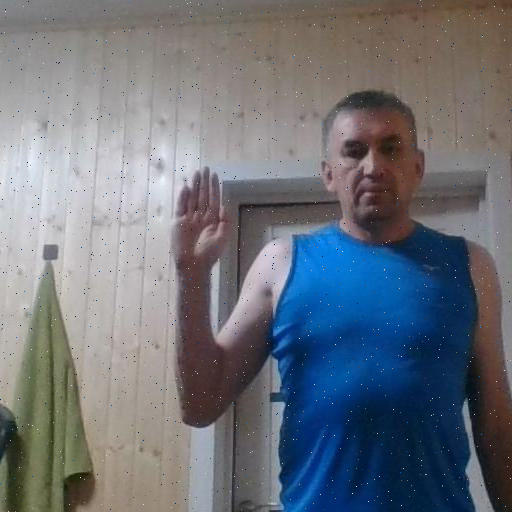

In [ ]:
rand_pixel_copy_tf = RandPixelCopy(pct=0.015)

# Convert the PIL image to a tensor
img_tensor = transforms.PILToTensor()(sample_img)
print(img_tensor.shape)

# Apply the `rand_pixel_copy_tf` transform to the image tensor
tensor_to_pil(rand_pixel_copy_tf(img_tensor))

The third combines the first two approaches by copying random squares and then applying the pixel copy transform on those squares. I use the same patch size range as the first augmentation but copy up to 100% of the pixels.

**Random Square Pixel Copy Transform**

In [ ]:
def rand_square_pixel_copy(img_tensor:torch.Tensor, square_pct:float, pixel_pct:float):
    """
    Copy data from a randomly selected set of pixels of a randomly selected square region to another randomly
    selected square region of a tensor.

    Args:
    img_tensor (torch.Tensor): The input tensor.
    square_pct (float): The percentage of the tensor's size to be used as the side length of the square regions.
    pixel_pct (float): The percentage of the pixels of the source square region to be copied.

    Returns:
    torch.Tensor: The modified input tensor.
    """
    # Get the shape of the tensor
    h, w = img_tensor.shape[-2:]
    
    # Calculate the size of the square
    szx = int(square_pct * h)
    szy = int(square_pct * w)
    
    # Calculate the top-left coordinate of the first square
    stx1 = int(random.random() * (1 - square_pct) * h)
    sty1 = int(random.random() * (1 - square_pct) * w)
    
    # Calculate the top-left coordinate of the second square
    stx2 = int(random.random() * (1 - square_pct) * h)
    sty2 = int(random.random() * (1 - square_pct) * w)
    
    # Copy the data from the second square to the first square
    source_pixels = rand_pixel_copy(img_tensor[..., stx2:stx2 + szx, sty2:sty2 + szy].clone(), pixel_pct)
    img_tensor[..., stx1:stx1 + szx, sty1:sty1 + szy] = source_pixels
    
    # Return the modified input tensor
    return img_tensor

In [ ]:
class RandSquarePixelCopy(nn.Module):
    def __init__(self, square_pct=0.2, pixel_pct=1.0, min_num=0, max_num=4):
        """
        A PyTorch module that applies the `rand_square_pixel_copy` function to an input tensor.

        Args:
        square_pct (float, optional): The percentage of the tensor's size to be used as the side length of the
                                      square regions.
        pixel_pct (float, optional): The maximum percentage of the pixels of the source square region to be copied.
        min_num (int, optional): The minimum number of times the `rand_square_pixel_copy` function is applied to
                                 the input tensor.
        max_num (int, optional): The maximum number of times the `rand_square_pixel_copy` function is applied to
                                 the input tensor.
        """
        super().__init__()
        self.square_pct = square_pct
        self.pixel_pct = pixel_pct
        self.min_num = min_num
        self.max_num = max_num
        
    def forward(self, x):
        # Apply the `rand_square_pixel_copy` function to the input tensor
        for i in range(random.randint(self.min_num, self.max_num)):
            x = rand_square_pixel_copy(x, 
                                       max(0.1,random.random()*self.square_pct), 
                                       max(0.0025, random.random()*self.pixel_pct))
        return x

**Test the transform**

torch.Size([3, 512, 512])


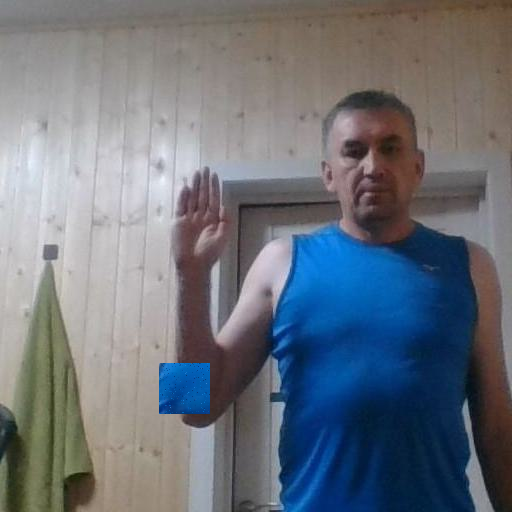

In [ ]:
rand_square_pixel_copy_tf = RandSquarePixelCopy(square_pct=0.2, pixel_pct=1.0, min_num=1, max_num=1)

img_tensor = transforms.PILToTensor()(sample_img)
print(img_tensor.shape)

tensor_to_pil(rand_square_pixel_copy_tf(img_tensor))

I also tested the [TrivialAugment](https://pytorch.org/vision/main/auto_examples/plot_transforms.html#trivialaugmentwide) augmentation from the paper linked below. TrivialAugment applies a single randomly selected transform to each image. I stuck with the default parameters.
* [TrivialAugment: Tuning-free Yet State-of-the-Art Data Augmentation](https://arxiv.org/abs/2103.10158)

**Trivial Augmentation**

torch.Size([1, 3, 512, 512])


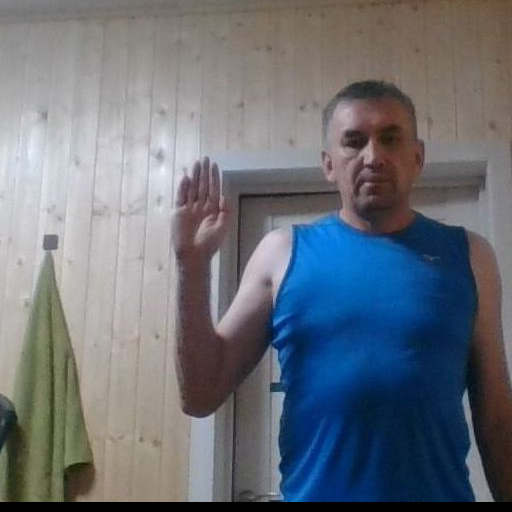

In [ ]:
# Create a TrivialAugmentWide object
trivial_aug = transforms.TrivialAugmentWide()

# Convert the image to a tensor
img_tensor = transforms.PILToTensor()(sample_img)[None]
print(img_tensor.shape)

# Apply the TrivialAugmentWide to the tensor
tensor_to_pil(trivial_aug(img_tensor))

Finally, inspired by the TrivialAugment transform, I created a custom trivial augmentation that randomly applies the random square copy, random rand pixel copy, random square pixel copy, or no transform.

**Custom Trivial Augmentation Transform**

In [ ]:
class CustomTrivAug(nn.Module):
    def __init__(self, aug_list):
        """
        A PyTorch module that applies a random image augmentation.

        Args:
        aug_list (list): List of functions that implement the desired augmentations.
        """
        super().__init__()
        self.aug_list = aug_list
        
    def forward(self, x):
        return random.choice(aug_list)(x)

**Test the transform**

torch.Size([3, 512, 512])


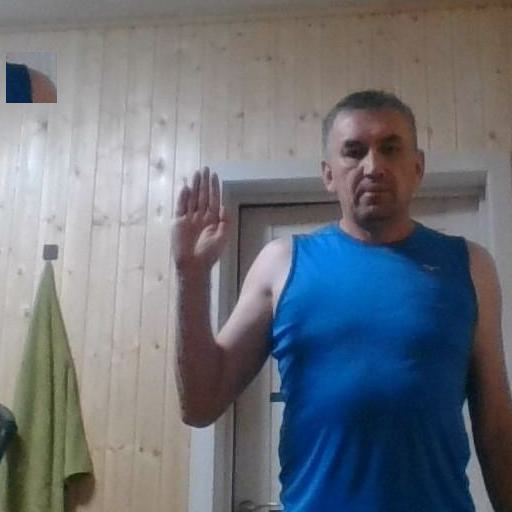

In [ ]:
aug_list = [
    # Identity transformation (no augmentation applied)
    lambda x:x,
    # Random square copy transformation
    rand_square_copy_tf,
    # Random pixel copy transformation
    rand_pixel_copy_tf,
    # Random square pixel copy transformation
    rand_square_pixel_copy_tf
]

# Create an instance of the CustomTrivAug module
custom_triv_aug_tf = CustomTrivAug(aug_list=aug_list)

# Convert a sample image to a tensor
img_tensor = transforms.PILToTensor()(sample_img)
print(img_tensor.shape)

# Apply a random augmentation and convert the tensor back to an image
tensor_to_pil(custom_triv_aug_tf(img_tensor))

### Model

I went with the pretrained [ResNet 18-D](https://github.com/huggingface/pytorch-image-models/blob/4b8cfa6c0a355a9b3cb2a77298b240213fb3b921/timm/models/resnet.py#L869) model from the [timm library](https://huggingface.co/docs/timm/index) for its balance of accuracy and speed.

**List available ResNet18 models**

In [ ]:
pd.DataFrame(timm.list_models('resnet18*', pretrained=True))

,0
0,resnet18
1,resnet18d


**Inspect config for ResNet18 model**

In [ ]:
# Import the resnet module
from timm.models import resnet

# Choose the resnet model
resnet_model = 'resnet18d'

# Get the default configuration of the chosen model as a Pandas DataFrame
pd.DataFrame.from_dict(resnet.default_cfgs[resnet_model], orient='index')

,0
url,https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet18d_ra2-48a79e06.pth
num_classes,1000
input_size,"(3, 224, 224)"
pool_size,"(7, 7)"
crop_pct,0.875
interpolation,bicubic
mean,"(0.485, 0.456, 0.406)"
std,"(0.229, 0.224, 0.225)"
first_conv,conv1.0
classifier,fc


We first get the normalization stats used to pre-train the model. We get the mean and standard deviation values for the red, green, and blue color channels from the `default_cfgs` dictionary.

**Get normalization stats**

In [ ]:
norm_stats = resnet.default_cfgs[resnet_model]['mean'], resnet.default_cfgs[resnet_model]['std']
norm_stats

((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

Next, we load the pretrained model and set the number of output classes for the model head. We'll also update the device and data type of the model to the ones specified earlier.

**Load ResNet18 model**

In [ ]:
# Load the resenet model
resnet18 = timm.create_model(resnet_model, pretrained=True, num_classes=len(class_names))

# Set the device, data type, and name
resnet18 = resnet18.to(device=device, dtype=dtype)
resnet18.device = device
resnet18.name = resnet_model

**Select model**

In [ ]:
model = resnet18

**Get model summary**

In [ ]:
# Define the input to the model
test_inp = torch.randn(1, 3, 256, 256).to(device)

# Get a summary of the model as a Pandas DataFrame
summary_df = markdown_to_pandas(f"{get_module_summary(model, [test_inp])}")

# Filter the summary to only contain Conv2d layers and the model
summary_df = summary_df[(summary_df.index == 0) | (summary_df['Type'] == 'Conv2d')]

# Remove the column "Contains Uninitialized Parameters?"
summary_df.drop('Contains Uninitialized Parameters?', axis=1)

,Type,# Parameters,# Trainable Parameters,Size (bytes),Forward FLOPs,Backward FLOPs,In size,Out size
0,ResNet,11.2 M,11.2 M,44.9 M,2.7 G,5.3 G,"[1, 3, 256, 256]","[1, 19]"
2,Conv2d,864,864,3.5 K,14.2 M,14.2 M,"[1, 3, 256, 256]","[1, 32, 128, 128]"
5,Conv2d,9.2 K,9.2 K,36.9 K,150 M,301 M,"[1, 32, 128, 128]","[1, 32, 128, 128]"
8,Conv2d,18.4 K,18.4 K,73.7 K,301 M,603 M,"[1, 32, 128, 128]","[1, 64, 128, 128]"
14,Conv2d,36.9 K,36.9 K,147 K,150 M,301 M,"[1, 64, 64, 64]","[1, 64, 64, 64]"
19,Conv2d,36.9 K,36.9 K,147 K,150 M,301 M,"[1, 64, 64, 64]","[1, 64, 64, 64]"
23,Conv2d,36.9 K,36.9 K,147 K,150 M,301 M,"[1, 64, 64, 64]","[1, 64, 64, 64]"
28,Conv2d,36.9 K,36.9 K,147 K,150 M,301 M,"[1, 64, 64, 64]","[1, 64, 64, 64]"
33,Conv2d,73.7 K,73.7 K,294 K,75.5 M,150 M,"[1, 64, 64, 64]","[1, 128, 32, 32]"
38,Conv2d,147 K,147 K,589 K,150 M,301 M,"[1, 128, 32, 32]","[1, 128, 32, 32]"


### Dataset Preparation

I split the dataset randomly into 90% for training and 10% for validation.

**Get training and validation sets**

In [ ]:
# Shuffle the image paths
random.shuffle(img_paths)

# Define the percentage of the images that should be used for training
train_pct = 0.9
val_pct = 0.1

# Calculate the index at which to split the subset of image paths into training and validation sets
train_split = int(len(img_paths)*train_pct)
val_split = int(len(img_paths)*(train_pct+val_pct))

# Split the subset of image paths into training and validation sets
train_paths = img_paths[:train_split]
val_paths = img_paths[train_split:]

# Print the number of images in the training and validation sets
len(train_paths), len(val_paths)

(138361, 15374)

The hand gestures in some images are hard to see at low resolutions, so I resized and padded the samples to `288x288` for training to balance computational efficiency and model performance. 

**Set training image size**

In [ ]:
train_sz = (288,288)

**Resize Pad Transform**

In [ ]:
class ResizePad(nn.Module):
    def __init__(self, max_sz=256, padding_mode='edge'):
        """
        A PyTorch module that resizes an image tensor and adds padding to make it a square tensor.

        Args:
        max_sz (int, optional): The size of the square tensor.
        padding_mode (str, optional): The padding mode used when adding padding to the tensor.
        """
        super().__init__()
        self.max_sz = max_sz
        self.padding_mode = padding_mode
        
    def forward(self, x):
        # Get the width and height of the image tensor
        w, h = TF.get_image_size(x)
        
        # Resize the image tensor so that its minimum dimension is equal to `max_sz`
        size = int(min(w, h) / (max(w, h) / self.max_sz))
        x = TF.resize(x, size=size)
        
        # Add padding to make the image tensor a square
        w, h = TF.get_image_size(x)
        offset = (self.max_sz - min(w, h)) // 2
        padding = [0, offset] if h < w else [offset, 0]
        x = TF.pad(x, padding=padding, padding_mode=self.padding_mode)
        x = TF.resize(x, size=[self.max_sz] * 2)
        
        return x

**Test the transform**

Source image: (512, 512)
Cropped image: (512, 256)
Cropped tensor: torch.Size([1, 3, 256, 512])
Padded tensor: torch.Size([1, 3, 288, 288])


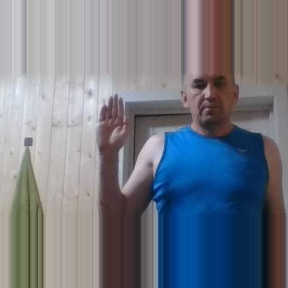

In [ ]:
print(f"Source image: {sample_img.size}")

# Crop the source image
w, h = sample_img.size
cropped_img = sample_img.crop([0, h//4, w, h-h//4])
print(f"Cropped image: {cropped_img.size}")

# Create a `ResizePad` object
resize_pad = ResizePad(max_sz=max(train_sz))

# Convert the cropped image to a tensor
img_tensor = transforms.PILToTensor()(cropped_img)[None]
print(f"Cropped tensor: {img_tensor.shape}")

# Resize and pad the tensor
resized_tensor = resize_pad(img_tensor)
print(f"Padded tensor: {resized_tensor.shape}")

# Apply random pixel copy to the resized and padded tensor
tensor_to_pil(resized_tensor)

The TrivialAugment transform requires PIL Images, so I applied all transforms per item rather than per batch for consistency.

**Set image transforms**

In [ ]:
# Set transforms for training set
train_tfms = [
    ResizePad(max_sz=max(train_sz)),
#     transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize(*norm_stats),
#     rand_square_copy_tf,
#     rand_pixel_copy_tf,
#     rand_square_pixel_copy_tf
    custom_triv_aug_tf,
]

# Set transforms for validation set
valid_tfms = [
    ResizePad(max_sz=max(train_sz)),
    transforms.ToTensor(),
    transforms.Normalize(*norm_stats),
]

We pass the list of transforms into a custom Dataset class along with the image paths and class names.

**Define training dataset class**

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, img_paths, classes, tfms):
        # Store the arguments as instance variables
        self.img_paths = img_paths
        self.classes = classes
        self.tfms = tfms
        
        # Create a mapping from class names to class indices
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

    def __len__(self):
        # Return the number of images in the dataset
        return len(self.img_paths)

    def __getitem__(self, index):
        # Get the path of the image at the given index
        img_path = self.img_paths[index]
        
        # Get the label of the image
        label = self.class_to_idx[img_path.parent.name]
        
        # Open the image
        image = Image.open(img_path).convert('RGB')
        
        return self.tfms(image), label

**Initialize datasets**

In [ ]:
# create the training dataset using the composed transformations
train_dataset = ImageDataset(img_paths=train_paths, 
                             classes=class_names,
                             tfms=transforms.Compose(train_tfms))

# create the validation dataset
valid_dataset = ImageDataset(img_paths=val_paths, 
                             classes=class_names,
                             tfms=transforms.Compose(valid_tfms))

# print the length of the training and validation datasets
len(train_dataset), len(valid_dataset)

(138361, 15374)

**Inspect training set sample**

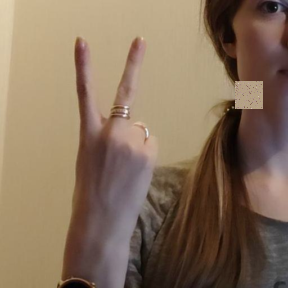

In [ ]:
tensor_to_pil(denorm_img_tensor(train_dataset[0][0], *norm_stats))

**Inspect validation set sample**

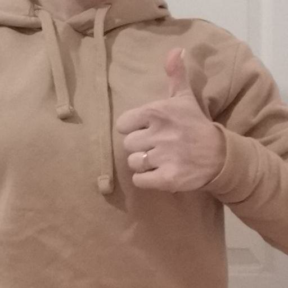

In [ ]:
tensor_to_pil(denorm_img_tensor(valid_dataset[0][0], *norm_stats))

**Set training batch size**

In [ ]:
bs = 32

**Initialzie dataloaders**

In [ ]:
train_dataloader = DataLoader(train_dataset, 
                              batch_size=bs, 
                              shuffle=True, 
                              num_workers=multiprocessing.cpu_count())

valid_dataloader = DataLoader(valid_dataset, batch_size=bs)

dls = DataLoaders(train_dataloader, valid_dataloader)

# Print the number of batches in the training and validation dataloaders
len(dls.train), len(dls.valid)

(4324, 481)

### Training

We can define a custom callback to integrate W&B with the miniai library. The one below tracks the loss and accuracy values for the training and validation sets.

**Define training callbacks**

In [ ]:
class WandBCB(MetricsCB):
    """
    A Callback class that integrates with the Weights and Biases (W&B) platform to log training 
    and validation metrics, as well as sample figures during training.
    """
    order=100
    
    def __init__(self, config, *ms, project:str, name:str=None, **metrics):
        """
        Initialize the WandBCB class.
        
        Parameters:
            config (dict): Configuration parameters for the W&B run.
            ms (list): List of metrics to be logged.
            project (str): The name of the W&B project.
            name (str, optional): The name of the W&B run. Defaults to None.
            metrics (dict, optional): Additional metrics to be logged.
        """
        fc.store_attr()
        self.train = False
        self.run = None
        super().__init__(*ms, **metrics)
        
    def before_fit(self, learn):
        """
        Initialize the W&B run.
        
        Parameters:
            learn (miniai.learner.Learner): The miniai Learner object.
        """
        # If a name for the run is provided, use it, otherwise use the default name
        if self.name:
            self.run = wandb.init(project=self.project, name=self.name, config=self.config)
        else:
            self.run = wandb.init(project=self.project, config=self.config)
            
    def after_fit(self, learn):
        """
        Finalize the W&B run.
        
        Parameters:
            learn (miniai.learner.Learner): The miniai Learner object.
        """
        wandb.finish()

    def _log(self, d):
        """
        Log the metrics to W&B.
        
        Parameters:
            d (dict): Dictionary of metrics.
        """
        # Log the metrics with a prefix of "train_" if in training mode, otherwise "val_"
        if self.train: 
            wandb.log({'train_'+m:float(d[m]) for m in self.all_metrics})
        else: 
            wandb.log({'val_'+m:float(d[m]) for m in self.all_metrics})

    def after_batch(self, learn):
        """
        Log the loss after a batch
        """
        super().after_batch(learn)
        # Log the batch loss to W&B
        wandb.log({'loss':learn.loss})
        
    def after_epoch(self, learn):
        """
        Update the training mode flag and call the parent class's `after_epoch` method.

        Parameters:
            learn (miniai.learner.Learner): The miniai Learner object.
        """
        # Update the training mode flag
        self.train = learn.training
        super().after_epoch(learn)

In [ ]:
class OutOfBoundsCB(Callback):
    """
    A callback that exits the training session if the loss is not NaN or infinite.
    """
    def __init__(self, msg="Loss out of bounds"):
        fc.store_attr()
        
    def after_loss(self, learn):
        """
        Check if the loss is NaN or infinite.
        """
        if learn.loss.detach().isnan() or learn.loss.detach().isinf(): 
            print(self.msg)
            raise CancelFitException()

**Initialize callbacks**

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())

cbs = [MixedPrecision(), 
       OutOfBoundsCB(),
       DeviceCB(), 
       metrics, 
       ProgressCB(plot=False),
      ]

**Set optimizer**

In [ ]:
opt_func = partial(torch.optim.AdamW, eps=1e-5)

**Set learning rate scheduler**

In [ ]:
lr = 1e-3
epochs = 3

tmax = epochs * len(dls.train)
sched = partial(torch.optim.lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs.append(BatchSchedCB(sched))

**Configure Weights & Biases project**

In [ ]:
project_name = f"miniai_data_augmentation_seed-{seed}"
# run_name = "baseline"
# run_name = "rand-square-cp-1"
# run_name = "rand-pixel-cp-1"
# run_name = "rand-square-pixel-cp-1"
# run_name = "trivial-aug-item-1"
run_name = "custom-trivial-aug-1"

project_config = {'lr':lr, 'epochs':epochs}

wandbcb =  WandBCB(config=project_config, 
                   project=project_name,
                   name=run_name,
                   accuracy=MulticlassAccuracy()
                  )
cbs.append(wandbcb)

**Initialize learner**

In [ ]:
learn = TrainLearner(model, dls, torch.nn.functional.cross_entropy, lr=lr, cbs=cbs, opt_func=opt_func)

**Train model**

In [ ]:
learn.fit(epochs)

accuracy,loss,epoch,train
0.905,0.343,0,train
0.966,0.113,0,eval
0.976,0.077,1,train
0.989,0.038,1,eval
0.994,0.021,2,train
0.994,0.021,2,eval


loss,█▃▂▂▁▂▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▇█
train_loss,█▂▁
val_accuracy,▁▇█
val_loss,█▂▁
loss,0.00186
train_accuracy,0.994
train_loss,0.021
val_accuracy,0.994
val_loss,0.021


**Set checkpoint directory**

In [ ]:
# Create a directory to store the checkpoints if it does not already exist
checkpoint_dir = Path(f"./{project_name}/")
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# Print the checkpoint path
checkpoint_dir

Path('miniai_data_augmentation_seed-1234')

**Save model checkpoint**

In [ ]:
torch.save(learn.model.state_dict(), checkpoint_dir/f"{model.name}-{run_name}.pth")

**Test model**

Class: rock
Predicted Class: rock


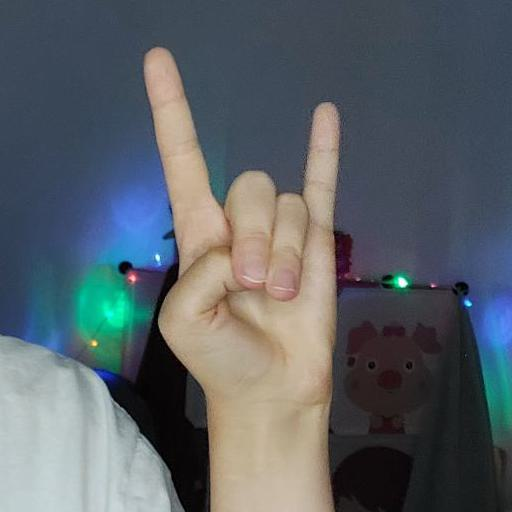

In [ ]:
infer_sz = max(train_sz)

# Choose a random image from the list of image paths
img_path = random.choice(img_paths)

# Print the actual class of the chosen image
print(f"Class: {img_path.parent.name}")

# Open the image and resize it
sample_img = Image.open(img_path)
inp_img = resize_img(sample_img.copy(), infer_sz)

# Convert the image to a tensor and move it to the device
img_tensor = pil_to_tensor(inp_img, *norm_stats).to(device=device)

# Make a prediction with the model
with torch.no_grad():
    pred = learn.model(img_tensor)

# Get the predicted class index and convert it to the class name
pred_class = train_dataset.classes[torch.argmax(torch.softmax(pred, dim=1))]

# Print the predicted class
print(f"Predicted Class: {pred_class}")

# Display the image
sample_img

## Results

All training runs, including the baseline no augmentation run, ended with over 99% accuracy across all random seeds. 

### Validation Set
The TrivialAugmentWide transform had the highest validation accuracy across three of four random seeds, but the scores were too close to name a definitive winner. 

Seed 1

Seed 42

Seed 100

Seed 1234

### Test Set
I also ended each run by testing the models without augmentation on the entire dataset. I used a minimum resolution of 288p, as I did for training but did not enforce square aspect ratios. The results were quite different from the validation sets.

**Perform inference on dataset**

In [ ]:
# Initialize a list to store the file paths of the images that were incorrectly classified
wrong_imgs = []

# Iterate through the test image paths
for path in tqdm(img_paths):
    # Get the actual class of the image
    target_cls = path.parent.name

    # Open and resize the image
    sample_img = Image.open(path)
    sample_img = resize_img(sample_img, infer_sz)

    # Convert the image to a tensor and move it to the device
    img_tensor = pil_to_tensor(sample_img, *norm_stats).to(device=device)

    # Make a prediction with the model
    with torch.no_grad():
        pred = learn.model(img_tensor)

    # Get the predicted class index and convert it to the class name
    pred_cls = train_dataset.classes[torch.argmax(torch.softmax(pred, dim=1))]

    # If the prediction is incorrect, add the file path to the list of wrong images
    if pred_cls != target_cls: 
        wrong_imgs.append(path)

len(wrong_imgs)

  0%|          | 0/153735 [00:00<?, ?it/s]

251

**Inspect the number of wrong predictions per class**

In [ ]:
# Create a DataFrame from the list of incorrectly classified images
wrong_imgs_df = pd.DataFrame(wrong_imgs)

# Add a column to the DataFrame with the actual class of each image
wrong_imgs_df['class'] = wrong_imgs_df.apply(lambda row: Path(row[0]).parent.stem, axis=1)

# Create a DataFrame with the class distribution of the incorrectly classified images
class_dist_df = wrong_imgs_df['class'].value_counts().to_frame().rename(columns={"class":run_name})

# Set the index name to "class"
class_dist_df.rename_axis("class", inplace=True)

# Display the class distribution DataFrame
class_dist_df

,custom-trivial-aug-1
class,
peace,27
one,23
three,22
no_gesture,22
stop,19
four,17
two_up,15
call,15
stop_inverted,13


**Save DataFrame**

In [ ]:
class_dist_df_path = checkpoint_dir/f"class_dist_df-{run_name}.json"
class_dist_df.to_json(class_dist_df_path)

With this seed, the `TrivialAugmentWide` model missed the second-most number of predictions during inference, even though it had the highest validation accuracy.

**Load and concatenate DataFrames**

In [ ]:
def get_class_dist_agg_df(folder, ext='json'):
    # Get a list of paths to `ext` files in the folder
    df_paths = glob(os.path.join(folder, f"*.{ext}"))
    
    # Create a generator that reads the class distribution data from each file in df_paths
    class_dist_dfs = (pd.read_json(f).rename_axis('class') for f in df_paths)

    # Concatenate the class distribution data into a single DataFrame
    return pd.concat(class_dist_dfs, axis=1, sort=False).fillna(0).astype(int)

In [ ]:
# Concatenate the class distribution data into a single DataFrame
class_dist_agg_df = get_class_dist_agg_df(checkpoint_dir)

# Compute the sum of the class distribution data for each run
sums = class_dist_agg_df.sum(axis=0)

# Add a row to the DataFrame with the totals
class_dist_agg_df.loc['Total'] = sums

# Fill any missing values with 0 and convert the values to integers
class_dist_agg_df.sort_values(by='Total', axis=1)

,rand-square-pixel-cp-1,baseline,rand-square-cp-1,custom-trivial-aug-1,trivial-aug-item-1,rand-pixel-cp-1
class,,,,,,
call,6,15,9,15,16,13
dislike,8,5,5,5,6,10
fist,11,8,9,10,13,21
four,25,19,15,17,22,31
like,18,11,15,12,19,14
mute,5,3,6,5,4,10
no_gesture,18,23,23,22,44,25
ok,5,15,11,8,8,7
one,14,22,28,23,21,19


Even though the TrivialAugmentWide transform seemed like the winner across the validation sets, it performed the worst overall during inference. The custom trivial augmentation transform performed the best overall, with the random square copy transform a close second.

**Compare performance across random seeds**

In [ ]:
# Get project folders
folder_prefix = project_name.split('-')[0]
project_folders = [f for f in os.listdir(".") if f.startswith(folder_prefix) and os.path.isdir(f)]

# Get the class distribution data for each random seed
df_list = [get_class_dist_agg_df(f).sum(axis=0).rename(int(f.split('-')[-1])) for f in project_folders]

# Concatenate the class distribution data across seeds into a single DataFrame
missing_imgs_df = pd.concat(df_list, axis=1, sort=False).transpose().sort_index()

# Compute the mean of the class distribution data for each run
mean_vals = missing_imgs_df.mean(axis=0).rename('Mean')

# Fill any missing values with 0, convert the values to integers, and sort the columns
mean_vals_df = mean_vals.to_frame().transpose().fillna(0).astype(int)

# Append mean values to DataFrame
pd.concat([missing_imgs_df, mean_vals_df], axis=0).sort_values(by='Mean', axis=1)

,custom-trivial-aug-1,rand-square-cp-1,rand-square-pixel-cp-1,baseline,rand-pixel-cp-1,trivial-aug-item-1
1,231,215,261,257,272,321
42,231,238,290,284,309,312
100,229,255,224,238,352,307
1234,251,246,213,243,317,312
Mean,235,238,247,255,312,313


**Sort runs for each random seed**

In [ ]:
# Define a lambda function to sort the column names based on their values in each row and return a new DataFrame
sort_cols = lambda row: pd.DataFrame({row.name: row.sort_values().index.tolist()}).transpose()

# Apply the lambda function to each row in the DataFrame and concatenate the results into a new DataFrame
sorted_cols_df = pd.concat(missing_imgs_df.apply(sort_cols, axis=1).tolist())

sorted_cols_df

,0,1,2,3,4,5
1,rand-square-cp-1,custom-trivial-aug-1,baseline,rand-square-pixel-cp-1,rand-pixel-cp-1,trivial-aug-item-1
42,custom-trivial-aug-1,rand-square-cp-1,baseline,rand-square-pixel-cp-1,rand-pixel-cp-1,trivial-aug-item-1
100,rand-square-pixel-cp-1,custom-trivial-aug-1,baseline,rand-square-cp-1,trivial-aug-item-1,rand-pixel-cp-1
1234,rand-square-pixel-cp-1,baseline,rand-square-cp-1,custom-trivial-aug-1,trivial-aug-item-1,rand-pixel-cp-1


## Discussion
The random square copy augmentation performed consistently well throughout my initial testing and final set of experiments. I thought this one might not work well with the hand gesture dataset as it could copy or cover parts of a hand. I assumed that would be an issue if the result were too close to another gesture class.

The random pixel copy transform did much worse than I expected on the validation sets and during inference. I thought it would be one of the better-performing augmentations since it was unlikely to obscure a hand. I am curious if some of the training images were already so noisy that adding more was too much.

Given how poorly the pixel copy transform performed relative to the others, I was surprised my custom trivial augmentation transform did the best on average.

Something I found interesting is that the trivial augmentation models initially performed far better during inference than the others. However, it lost that lead as I cleaned up the dataset. I wonder if the more extreme augmentations included with that transform help with a dirty dataset? With the cleaned-up dataset, I believe some of the included transforms altered the images too much. 

Looking to the future, recent improvements in fine-grained control for generative models like ControlNet for Stable Diffusion may make synthetic datasets more comparable to real-world images. I plan to explore this approach in future experiments to see if it can improve the performance of deep learning models trained on visual data.

## Conclusion
My findings suggest that different datasets may require different augmentation strategies, and it's important to test multiple augmentations to find the best one for a particular dataset. In addition, factors such as the complexity and quality of the dataset and the type of deep learning model may influence the performance of image augmentations. 

However, the square-copy transform delivered the best bang for the buck in these experiments. It is nearly tied with the custom trivial augmentation for overall performance and is simple to implement.

Of course, experiments with a known dataset are no substitute for real-world testing. Therefore, I encourage you to try the in-browser demos I've provided to test the models trained with different augmentations using your webcam. 

The models run locally in your browser using the Barracuda inference library for Unity. I selected the best-performing runs for each image augmentation to give them their best shot. Let me know which one performs best for you in the comments.